# IMaGES on ROI time series

In [1]:
import os
import pickle
from os.path import join as pjoin
import glob
import pandas as pd
import numpy as np
import pydot
from IPython.display import SVG
import matplotlib.pyplot as plt
from matplotlib import pyplot, patches
from pycausal import pycausal as pc
from pycausal import search as s
import networkx as nx
from networkx.drawing import nx_pydot
import itertools

In [2]:
%matplotlib inline

In [3]:
def getdfs(csvdir):
    """give us list of data frames for csv files in directory"""
    dfs = []
    for csvfile in glob.glob(csvdir_allruns + os.sep + "*.csv"):
        df = pd.read_csv(csvfile)
        dfs.append(df)
    return dfs

## Preprocessed BOLD data

In [14]:
# directory with csv files for roi time series (seperate csv file for each run)
csvdir_allruns = pjoin('/host', 'famfaces', 'extract_meants', 'csv', 'allruns')
dfs = getdfs(csvdir_allruns)

In [15]:
# perform images search
pc.start_vm() # start
images = s.imagesSemBic(dfs, verbose = True)
pc.stop_vm() # stop

In [16]:
# show nodes
# images.getNodes()

In [17]:
# show edges
# images.getEdges()

In [18]:
# render resulting graph
dot = images.getDot()
svg_str = dot.create_svg(prog='dot')
# SVG(svg_str)

## Residuals

From a nuisance model with motion parameters, outliers, and button press as regressors.

In [5]:
# nuisance data with button press
dfs_nb = getdfs(pjoin('/host', 'famfaces', 'extract_meants_nuisance_button', 'csv', 'run*'))

In [6]:
# perform images search
pc.start_vm() # start
images_nb = s.imagesSemBic(dfs_nb, verbose = True)
pc.stop_vm() # stop

In [7]:
# nodes and edges
# images_nb.getNodes()
# images_nb.getEdges()  

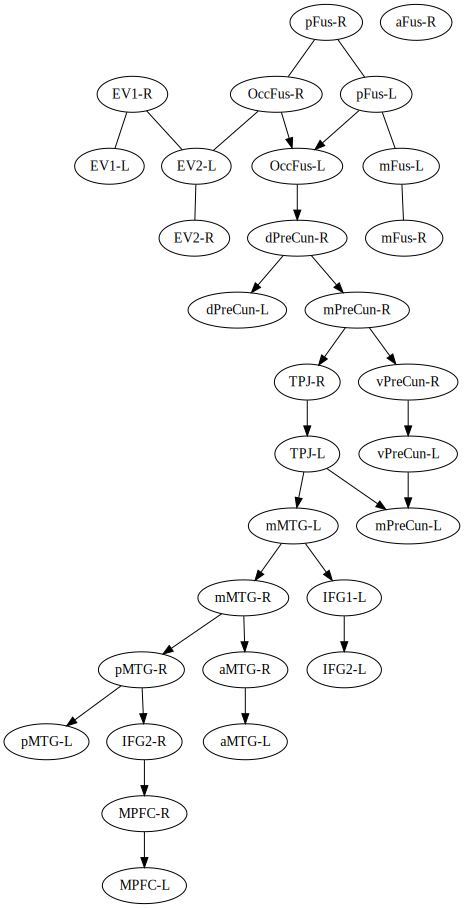

In [8]:
# render resulting graph
dot_nb = images_nb.getDot()
SVG(dot_nb.create_svg(prog='dot'))

# extract directed edges from images object *manually*

In [19]:
def splitpair(pair):
    """
    split string containing two nodes into a tuple of two nodes.
    ignore directedness of connection.
    Used in get_adjacencies.
    """
    split = tuple([label.replace('- ', '').replace('> ', '').replace(' ', '') # looks ugly, but is supposedly faster
                   for label in pair.split('--')])
    return split

In [20]:
def get_adjacencies(images_instance):
    """
    returns a list of tuples of connected nodes (i.e. pairs)
    """
    
    # get edges and convert from unicode to string
    images_edges = images_instance.edges
    edgestrings = [str(edge) for edge in images_edges]
    
    # split the strings to get tuples, turn into arrays and sort
    edges = np.array([splitpair(pair) for pair in edgestrings])
    connections = edges[np.argsort(edges[:, 0])]
    
    return connections

**TODO:** Very important! Assert that the length of all arrays is 30, when I start comparing them. Also, be sure that the order of the ROIs is exactly the same in each instance. To do so, save the first extracted connection arrays as a template and compare all following ones, wether the first column is identical to the template.

In [21]:
# apply above functions and inspect results
# connections = get_adjacencies(images_nb)
# connections

In [22]:
# plt.imshow(mixed_am_from_images(images_nb))

# to networkx

**Problems with networkx**

I suspect that when loading the pydot from images into networkx, some things go wrong:

1) all connections are directed (see graph visualization below)

2) This leads to an adjacency matrix that is asymmetrical and more sparse

3) I suspect this is because networkx has no object for graphs with both directed and undirected edges

In [23]:
# switch from images.pydot to nx graph
graph_raw = nx_pydot.from_pydot(dot)
graph_nb = nx_pydot.from_pydot(dot_nb)

# check if the nx adj matrix is identical to the one we extracted manually (nope)
from_nx = nx.to_numpy_matrix(graph_nb)
# from_nx == adjacency_matrix

In [24]:
def get_sorted_matrix_nx(G):
    """
    Use nx inherent method to extract numpy matrix from given graph object.
    rows and columns will be sorted by node label alphabetically.
    """
    node_order = sorted(G.nodes())
    adjacency_matrix = nx.to_numpy_matrix(G, dtype=np.bool, nodelist=node_order)
    return adjacency_matrix

In [25]:
# testmatrix = get_sorted_matrix_nx(graph_nb)
# testmatrix

## make graph undirected

In [26]:
# und_nb = graph_nb.to_undirected()

In [27]:
# positions=nx.spring_layout(graph_nb,iterations=30)
# plt.figure(figsize=(12,12)) 
# nx.draw_networkx(und_nb, pos=positions)
# plt.show()

In [28]:
# adjacency matrix of the new undirected graph
# am_und = get_sorted_matrix_nx(und_nb)
# am_und

# plot adjacency matrix

In [29]:
def plot_am_from_nx(G, node_order=None, partitions=[], colors=[], figsz=(5,5)):
    """
    - G is a netorkx graph
    - node_order (optional) is a list of nodes, where each node in G
          appears exactly once
    - partitions is a list of node lists, where each node in G appears
          in exactly one node list
    - colors is a list of strings indicating what color each
          partition should be
    If partitions is specified, the same number of colors needs to be
    specified.
    
    adapted from: http://sociograph.blogspot.de/2012/11/visualizing-adjacency-matrices-in-python.html
    """
    adjacency_matrix = nx.to_numpy_matrix(G, dtype=np.bool, nodelist=node_order)

    #Plot adjacency matrix in toned-down black and white
    fig = pyplot.figure(figsize=figsz) # in inches
    pyplot.imshow(adjacency_matrix,
                  cmap="binary",
                  interpolation="none")
    
    # add labels as axes ticks
    plt.xticks(np.arange(0,30), node_order, rotation='vertical')
    plt.yticks(np.arange(0,30), node_order)

    # add a grid
    ax=plt.gca()
    ax.set_xticks([x-0.5 for x in range(0,30)],minor=True )
    ax.set_yticks([y-0.5 for y in range(0,30)],minor=True)
    #plot grid on minor axes
    plt.grid(which="minor",ls="-",lw=1)
    
    # The rest is just if you have sorted nodes by a partition and want to
    # highlight the module boundaries
    assert len(partitions) == len(colors)
    ax = pyplot.gca()
    for partition, color in zip(partitions, colors):
        current_idx = 0
        for module in partition:
            ax.add_patch(patches.Rectangle((current_idx, current_idx),
                                          len(module), # Width
                                          len(module), # Height
                                          facecolor="none",
                                          edgecolor=color,
                                          linewidth="1"))
            current_idx += len(module)
            
    return fig

In [30]:
# matrixplot = plot_am_from_nx(G=graph_nb, figsz=(6,6), node_order=sorted(graph_nb.nodes()))

# Simple matching

return the fraction of identical elements between two arrays

In [32]:
def simple_match(m1, m2):
    """
    return the relative number of identical elements between two arrays.
    """
    assert np.shape(m1) == np.shape(m2)
    return float(np.sum(m1 == m2)) / float(m1.size)

## of undirected graphs

In [33]:
basedir = '/host/famfaces/extract_meants_nuisance_button/csv'
rundirs = [pjoin(basedir, 'run%02d' % i) for i in xrange(1,12)]

In [34]:
def csv2am_undirected(rundir):
    """
    Procedure to run images over all datasets in one run,
    convert to nx, make graph undirected, and extract
    sorted adjacency matrix.
    """
    # get dataframes
    dfs = getdfs(rundir)  
    # perform iamges
    pc.start_vm()
    images = s.imagesSemBic(dfs, verbose = True)
    pc.stop_vm()
    # convert images to nx via pydot
    G = nx_pydot.from_pydot(images.getDot()) 
    G_undir = G.to_undirected() # make graph undirected
    # get sorted adjacency matrix
    am = get_sorted_matrix_nx(G_undir)
    return am

In [35]:
def get_all_ams(rundirs):
    """
    get adjacency matrices of all runs
    """
    am_list = [csv2am_undirected(rundir) for rundir in rundirs]
    return am_list

In [36]:
## this command takes a while to execute
# am_list = get_all_ams(rundirs)

In [40]:
# save am_list as pickle
# with open('am_list.pickle', 'wb') as handle:
#     pickle.dump(am_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('am_list.pickle', 'rb') as handle:
    am_list = pickle.load(handle)

In [41]:
def compare_runs(am_list, method='simple'):
    """finish me :)"""
    
    if method=='simple':
        match_list = np.array([
            [simple_match(am1, am2) for am1 in am_list]
            for am2 in am_list])
        
    return match_list

In [42]:
match_matrix = compare_runs(am_list)

In [43]:
match_matrix

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]])

## conclusion: undirected edges

The edges of the network do not change over the course of the experiment. The functional connectivity as estimated by IMaGES doesn't change. Next, we investigate potential changes in effected connectivity, i.e. directed edges.

# Directionality

In [44]:
def get_mixed_adjacency_dicts(images_instance):
    """
    create a list of dicts, each containing the pair of nodes
    and wether edge is directed.
    """
    edgestrings = [str(edge) for edge in images_instance.edges]
    
    pairdicts = []
    for element in sorted(edgestrings):
        pairdict = {}
        if '-->' in element:
            pairdict['directed'] = True
            pair = element.split('-->')
        else:
            pairdict['directed'] = False
            pair = [word.replace('- ', '')
                    for word in element.split('--')]

        # remove whitespace and append
        pairdict['pair'] = [string.replace(' ', '') for string in pair]
        pairdicts.append(pairdict)
    return pairdicts

In [46]:
adjacency_dicts = get_mixed_adjacency_dicts(images_nb)
adjacency_dicts

[{'directed': False, 'pair': ['EV1-R', 'EV1-L']},
 {'directed': False, 'pair': ['EV1-R', 'EV2-L']},
 {'directed': False, 'pair': ['EV2-L', 'EV2-R']},
 {'directed': True, 'pair': ['IFG1-L', 'IFG2-L']},
 {'directed': True, 'pair': ['IFG2-R', 'MPFC-R']},
 {'directed': True, 'pair': ['MPFC-R', 'MPFC-L']},
 {'directed': True, 'pair': ['OccFus-L', 'dPreCun-R']},
 {'directed': False, 'pair': ['OccFus-R', 'EV2-L']},
 {'directed': True, 'pair': ['OccFus-R', 'OccFus-L']},
 {'directed': True, 'pair': ['TPJ-L', 'mMTG-L']},
 {'directed': True, 'pair': ['TPJ-L', 'mPreCun-L']},
 {'directed': True, 'pair': ['TPJ-R', 'TPJ-L']},
 {'directed': True, 'pair': ['aMTG-R', 'aMTG-L']},
 {'directed': True, 'pair': ['dPreCun-R', 'dPreCun-L']},
 {'directed': True, 'pair': ['dPreCun-R', 'mPreCun-R']},
 {'directed': False, 'pair': ['mFus-L', 'mFus-R']},
 {'directed': True, 'pair': ['mMTG-L', 'IFG1-L']},
 {'directed': True, 'pair': ['mMTG-L', 'mMTG-R']},
 {'directed': True, 'pair': ['mMTG-R', 'aMTG-R']},
 {'directed

In [47]:
def mixed_am_from_images(images_instance):
    
    # get nodes and dict of adjacencies (mixed)
    adjacency_dicts = get_mixed_adjacency_dicts(images_instance)
    nodes = [str(node) for node in images_instance.nodes]

    # initiate empty matrix
    am = np.zeros((len(nodes),len(nodes)))
    
    for edgedict in adjacency_dicts:
        # find out node indices for source and target
        source_index = nodes.index(edgedict['pair'][0])
        target_index = nodes.index(edgedict['pair'][1])
        # fill in matrix
        am[source_index, target_index] = 1
        # for undirected edges, also fill in on other side of diagonal
        if not edgedict['directed']:
            am[target_index, source_index] = 1
    return am

## iterate over runs

In [51]:
def csv2mixed_am(rundir):
    """
    run images on csv directory and extract mixed adjacency matrix
    """
    # get dataframes
    dfs = getdfs(rundir)  
    # perform iamges
    pc.start_vm()
    images_instance = s.imagesSemBic(dfs, verbose = True)
    pc.stop_vm()
    # get mixed adjacency matrix
    am = mixed_am_from_images(images_instance)
    return am

In [56]:
mixed_ams = [csv2mixed_am(rundir) for rundir in rundirs]

In [75]:
mixed_ams

[array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0

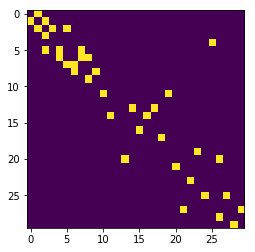

In [76]:
# inspect first am
plt.imshow(mixed_ams[0])

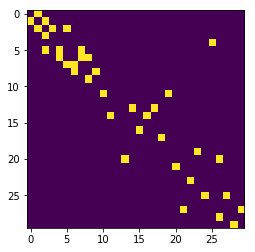

In [77]:
plt.imshow(mixed_ams[1])

In [58]:
# with open('mixed_ams.pickle', 'wb') as handle:
#     pickle.dump(mixed_ams, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [72]:
simple_matches_directed = np.array([[simple_match(am1, am2) for am1 in mixed_ams] for am2 in mixed_ams])

In [74]:
simple_matches_directed

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]])

In [67]:
mixed_ams[0] == mixed_ams[1]

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [ True,  True,  True,